<a href="https://colab.research.google.com/github/gantir/eva4/blob/develop/s9/s9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
# Manually unpgrading albumentations so the issue with ContextVersion not found when installing evalib is removed.
!pip uninstall albumentations -y
!pip uninstall imgaug -y
!pip install albumentations --upgrade

In [0]:
!pip install git+https://github.com/gantir/evalib.git@develop

In [4]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/')
except:
  print('May be not using Google Colab')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
from __future__ import print_function
import sys
from argparse import Namespace

import torch
import torchvision
from torchvision import  transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import numpy as np
from matplotlib.pyplot import imshow

In [6]:
import evalib
from evalib.gradcam.gradcam import GradCAM, GradCAMpp
from evalib.gradcam.utils import visualize_cam

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
def configure_optimizers(params, conf):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params, lr=conf.lr, momentum=0.9, weight_decay=conf.l2_decay)
  scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
  return criterion, optimizer, scheduler

In [0]:
config = Namespace(
    batch_size = 64,
    batch_size_cuda = 64,
    num_workers = 4,
    SEED = 170,
    EPOCHS = 25,
    dropout = 0.0,
    lr = 1e-3,
    l1_decay =  0,
    l2_decay = 1e-4   
)
evalib.utils.init_seed(config.SEED)

In [9]:
data = evalib.data.cifar.CIFAR(config)

Extracting ./data/cifar-10-python.tar.gz to ./data


  car   cat  deer plane


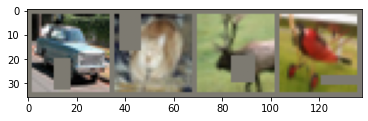

In [10]:
import numpy as np
from matplotlib import pyplot as plt

data_iter = iter(data.train_loader)
images, labels = data_iter.next()
index_start, index_end = 32,36
evalib.plot.imshow_torch(torchvision.utils.make_grid(images[index_start:index_end]))
print(' '.join('%5s' % data.classes[label] for label in labels[index_start:index_end]))

# imshow(transforms.ToPILImage()(images[32]))

In [11]:
net = evalib.models.resnet.ResNet18(config.dropout)
model = net.to(evalib.utils.get_device())
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
criterion, optimizer, scheduler = configure_optimizers(model.parameters(), config)

In [14]:
[(train_acc, train_loss), (val_acc, val_loss)] = evalib.tnt.train_n_test(model, criterion, optimizer, scheduler, data.train_loader, data.test_loader, num_epochs=config.EPOCHS)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


Batch Id/Size: 782/50000, Training Loss: 2.06531644, Training Accuracy: 45.2540%: 100%|██████████| 782/782 [01:54<00:00,  6.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01838635, Test Accuracy: 57.5700%

LR: [0.001]
Epoch: 2


Batch Id/Size: 782/50000, Training Loss: 1.34384537, Training Accuracy: 61.0460%: 100%|██████████| 782/782 [01:52<00:00,  6.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01428801, Test Accuracy: 67.9300%

LR: [0.001]
Epoch: 3


Batch Id/Size: 782/50000, Training Loss: 1.26886797, Training Accuracy: 68.5360%: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01293884, Test Accuracy: 71.7000%

LR: [0.001]
Epoch: 4


Batch Id/Size: 782/50000, Training Loss: 0.95399475, Training Accuracy: 72.9200%: 100%|██████████| 782/782 [01:50<00:00,  7.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01262624, Test Accuracy: 73.3000%

LR: [0.001]
Epoch: 5


Batch Id/Size: 782/50000, Training Loss: 0.63719958, Training Accuracy: 75.6340%: 100%|██████████| 782/782 [01:53<00:00,  6.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01035851, Test Accuracy: 77.3400%

LR: [0.001]
Epoch: 6


Batch Id/Size: 782/50000, Training Loss: 0.64799976, Training Accuracy: 77.9700%: 100%|██████████| 782/782 [01:55<00:00,  6.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00884729, Test Accuracy: 80.8000%

LR: [0.001]
Epoch: 7


Batch Id/Size: 782/50000, Training Loss: 0.70039177, Training Accuracy: 80.0660%: 100%|██████████| 782/782 [01:48<00:00,  7.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00852364, Test Accuracy: 81.4300%

LR: [0.001]
Epoch: 8


Batch Id/Size: 782/50000, Training Loss: 0.49734110, Training Accuracy: 81.8320%: 100%|██████████| 782/782 [01:53<00:00,  6.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00941640, Test Accuracy: 80.4000%

LR: [0.001]
Epoch: 9


Batch Id/Size: 782/50000, Training Loss: 0.48682067, Training Accuracy: 82.7680%: 100%|██████████| 782/782 [01:52<00:00,  6.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00827985, Test Accuracy: 82.2700%

LR: [0.001]
Epoch: 10


Batch Id/Size: 782/50000, Training Loss: 0.71453726, Training Accuracy: 84.0440%: 100%|██████████| 782/782 [01:50<00:00,  7.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00802058, Test Accuracy: 82.9900%

LR: [0.001]
Epoch: 11


Batch Id/Size: 782/50000, Training Loss: 0.32302767, Training Accuracy: 85.1240%: 100%|██████████| 782/782 [01:50<00:00,  7.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00822555, Test Accuracy: 83.1700%

LR: [0.001]
Epoch: 12


Batch Id/Size: 782/50000, Training Loss: 0.10896444, Training Accuracy: 86.2600%: 100%|██████████| 782/782 [01:53<00:00,  6.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00768575, Test Accuracy: 83.9100%

LR: [0.001]
Epoch: 13


Batch Id/Size: 782/50000, Training Loss: 0.36491796, Training Accuracy: 87.1760%: 100%|██████████| 782/782 [01:53<00:00,  6.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00762744, Test Accuracy: 84.1200%

LR: [0.001]
Epoch: 14


Batch Id/Size: 782/50000, Training Loss: 0.17989105, Training Accuracy: 87.9180%: 100%|██████████| 782/782 [01:49<00:00,  7.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00711991, Test Accuracy: 84.9700%

LR: [0.001]
Epoch: 15


Batch Id/Size: 782/50000, Training Loss: 0.07845548, Training Accuracy: 88.5280%: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00753413, Test Accuracy: 84.7300%

LR: [0.001]
Epoch: 16


Batch Id/Size: 782/50000, Training Loss: 0.40167409, Training Accuracy: 89.1040%: 100%|██████████| 782/782 [01:52<00:00,  6.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00702884, Test Accuracy: 85.3800%

LR: [0.001]
Epoch: 17


Batch Id/Size: 782/50000, Training Loss: 0.23233557, Training Accuracy: 89.8760%: 100%|██████████| 782/782 [01:54<00:00,  6.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00688129, Test Accuracy: 86.1500%

LR: [0.001]
Epoch: 18


Batch Id/Size: 782/50000, Training Loss: 0.19291501, Training Accuracy: 90.2280%: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00728085, Test Accuracy: 85.3600%

LR: [0.001]
Epoch: 19


Batch Id/Size: 782/50000, Training Loss: 0.04796362, Training Accuracy: 90.7280%: 100%|██████████| 782/782 [01:52<00:00,  6.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00686359, Test Accuracy: 86.2300%

LR: [0.001]
Epoch: 20


Batch Id/Size: 782/50000, Training Loss: 0.09686022, Training Accuracy: 91.4000%: 100%|██████████| 782/782 [01:52<00:00,  6.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00703567, Test Accuracy: 86.0100%

LR: [0.001]
Epoch: 21


Batch Id/Size: 782/50000, Training Loss: 0.26271552, Training Accuracy: 91.7960%: 100%|██████████| 782/782 [01:53<00:00,  6.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00684751, Test Accuracy: 86.3300%

LR: [0.001]
Epoch: 22


Batch Id/Size: 782/50000, Training Loss: 0.06204715, Training Accuracy: 92.2280%: 100%|██████████| 782/782 [01:49<00:00,  7.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00726282, Test Accuracy: 86.0400%

LR: [0.001]
Epoch: 23


Batch Id/Size: 782/50000, Training Loss: 0.14231187, Training Accuracy: 92.7080%: 100%|██████████| 782/782 [01:52<00:00,  6.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00736153, Test Accuracy: 85.7400%

LR: [0.001]
Epoch: 24


Batch Id/Size: 782/50000, Training Loss: 0.03766474, Training Accuracy: 92.6940%: 100%|██████████| 782/782 [01:52<00:00,  6.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00691655, Test Accuracy: 86.6100%

LR: [0.001]
Epoch: 25


Batch Id/Size: 782/50000, Training Loss: 0.11491519, Training Accuracy: 93.4080%: 100%|██████████| 782/782 [01:54<00:00,  6.82it/s]
100%|██████████| 157/157 [00:06<00:00, 22.48it/s]


Batch Id/Size: 157/10000, Test Loss: 0.00709029, Test Accuracy: 86.5100%

LR: [0.001]


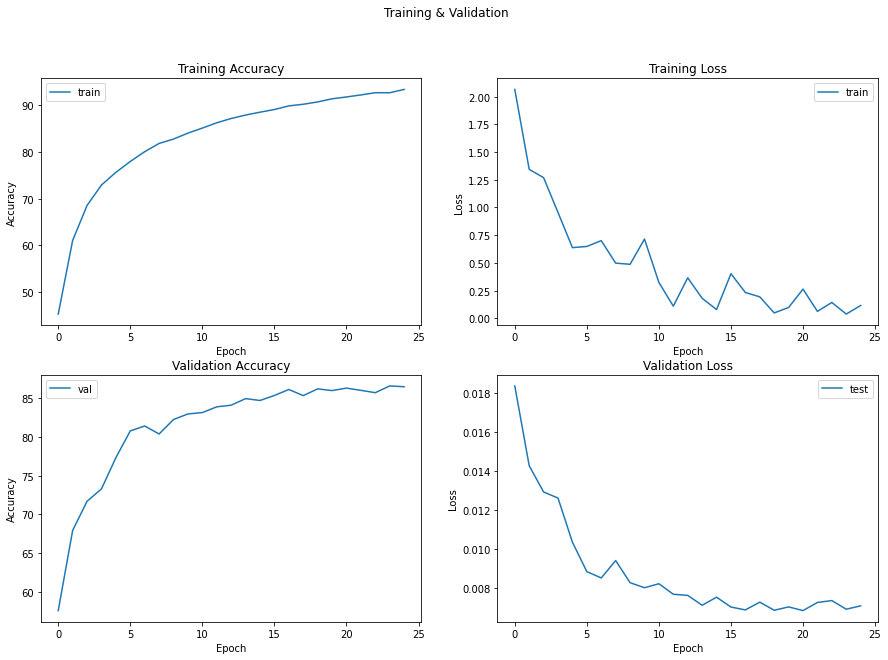

In [15]:
evalib.plot.plot_acc_loss(
    {'train': train_acc},
    {'val': val_acc},
    {'train': train_loss},
    {'test': val_loss}
)

In [0]:
c,w = evalib.tnt.get_correct_wrong_predictions(model, data.test_loader,count=25)

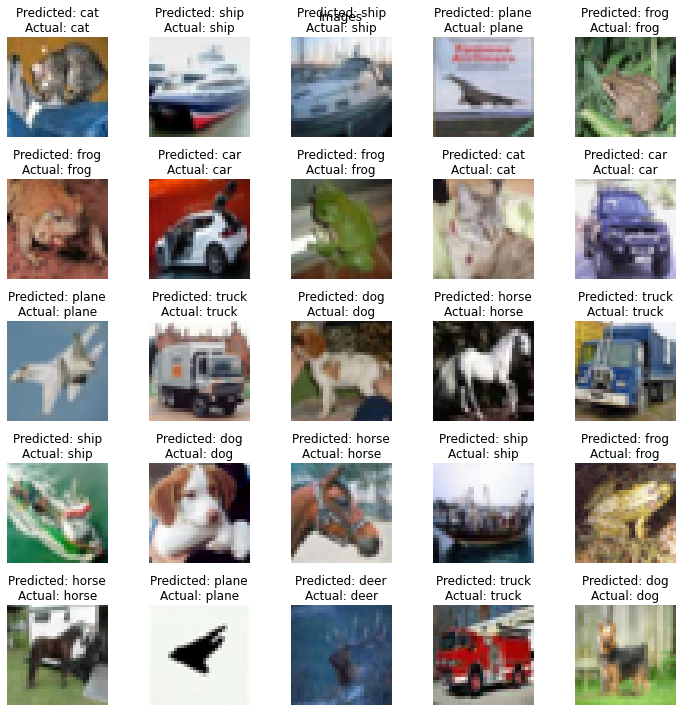

In [17]:
evalib.plot.plot_images(c, data.classes, "correct_imgs.png")

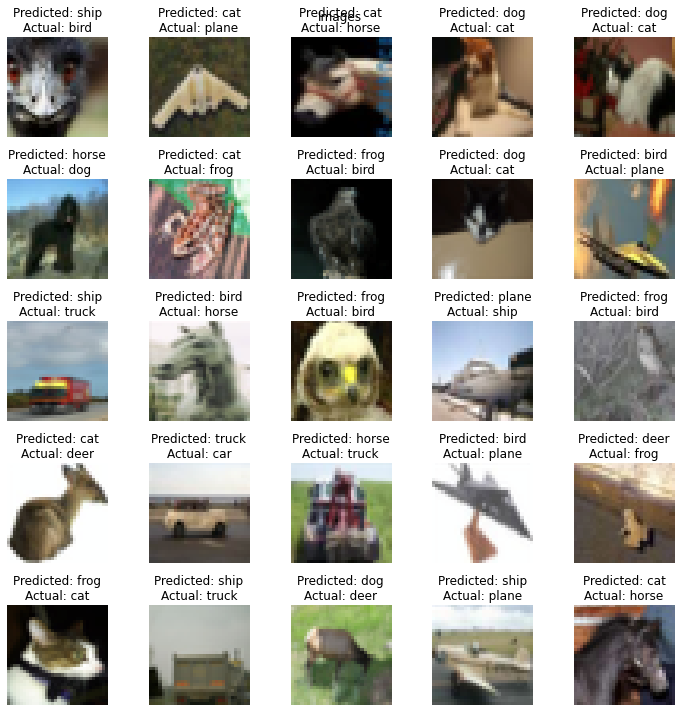

In [18]:
evalib.plot.plot_images(w, data.classes, "Wrong_imgs.png")

In [0]:
# Grad Cam
configs = [
    dict(model_type='resnet', arch=model, layer_name='layer1'),
    dict(model_type='resnet', arch=model, layer_name='layer2'),
    dict(model_type='resnet', arch=model, layer_name='layer3'),
    dict(model_type='resnet', arch=model, layer_name='layer4'),
]

for config in configs:
    config['arch'].to(evalib.utils.get_device()).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [0]:
torch_images = [i['img'].to(evalib.utils.get_device()) for i in w]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


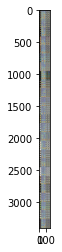

In [22]:
images = []
for torch_img in torch_images:
  normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
  for gradcam, gradcam_pp in cams:
      mask, _ = gradcam(normed_torch_img)
      heatmap, result = visualize_cam(mask, torch_img)

      mask_pp, _ = gradcam_pp(normed_torch_img)
      heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
      
      images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

grid_image = torchvision.utils.make_grid(images, nrow=5)
evalib.plot.imshow_torch(grid_image)